# Section 1: Training

## 1)  Importing the required packages

In [ ]:
!git clone https://github.com/gunnusravani/CS626_assignment.git

fatal: destination path 'CS626_assignment' already exists and is not an empty directory.


In [ ]:
from collections import defaultdict
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import brown
from sklearn.model_selection import KFold
from prettytable import PrettyTable

## 2)Downloading Dataset

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')

tags = set(w[1] for w in brown.tagged_words(tagset='universal'))
all_known_words = set(brown.words())
print(all_known_words)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


{'croupier', 'case-by-case', 'Augustin', 'overeat', 'Racing', 'propylthiouracil', 'justness', 'releasing', 'Thyroglobulin', 'cold-bloodedly', 'encumbered', 'ten-fifty-five', 'accented', 'challenging', 'dictum', 'Jerez', 'Inca', 'viewed', 'rhythmically', 'Hints', 'louvers', 'mahogany', 'creations', 'Hillsdale', 'assures', 'retina', 'Memphis', 'near-blind', 'incessantly', 'roles', 'L.', 'rotting', 'self-imposed', 'inflexible', 'forepart', 'Kupcinet', 'Metronome', 'labor', 'subverting', 'reared', 'fairs', 'pyramids', 'arrogance', 'majored', 'fumbling', 'stewardess', 'stout', 'city', 'satire', 'tow', 'flats', '$1,450,000,000', 'Wash.', 'buttery', 'piteous', 'piling', 'Commons', 'knuckle-duster', 'Survival', "Kissin'", 'there', 'silicon', 'Palaces', 'omen', 'irritates', 'Unoccupied', 'room', 'restaurants', 'phase', 'flautist', 'Aye-yah-ah-ah', 'world-ignoring', 'nominated', 'affirming', 'locked', 'LITORIGIN', 'cockatoo', 'Odilo', 'hallucinating', 'casework', 'slang', 'Trinitarians', 'klaxon

## 3) Defining HMM class

In [ ]:

class HMM:
    def __init__(self, smoothing=1):
        self.emissions = defaultdict(dict)
        self.transitions = defaultdict(dict)
        self.tags = set(tags).union({'^'})
        self.smoothing = smoothing

    def train(self, dataset):

        for sent in dataset:
            sent = sent[:]
            sent.insert(0, ('^', '^'))
            for word, tag in sent:
                word = word.lower()
                if word in self.emissions[tag]:
                    self.emissions[tag][word] += 1
                else:
                    self.emissions[tag][word] = 1


            for i, (word, tag) in enumerate(sent):
                if i == 0:
                    continue
                prev_tag = sent[i-1][1]
                if tag in self.transitions[prev_tag]:
                    self.transitions[prev_tag][tag] += 1
                else:
                    self.transitions[prev_tag][tag] = 1


        for tag in self.emissions:
            if tag == '^':
                continue

            total = sum(self.emissions[tag].values()) + (self.smoothing * (len(all_known_words) + 1))
            for word in all_known_words:
                word = word.lower()
                if word not in self.emissions[tag]:
                    self.emissions[tag][word] = self.smoothing

            self.emissions[tag] = {word: (count + self.smoothing) / total for word, count in self.emissions[tag].items()}

            self.emissions[tag]["unknown"] = self.smoothing / total


        for tag1 in self.transitions:
            total = sum(self.transitions[tag1].values()) + (self.smoothing * len(self.tags))
            for tag2 in self.tags:
                if tag2 not in self.transitions[tag1]:
                    self.transitions[tag1][tag2] = self.smoothing

            self.transitions[tag1] = {tag2: (count + self.smoothing) / total for tag2, count in self.transitions[tag1].items()}


    def tag_pos(self, sentence):
        sentence = [x if x in all_known_words else 'unknown' for x in sentence]
        sentence.insert(0, '^')
        matrix_final = [{tag: (0, ) for tag in self.tags} for _ in sentence]
        matrix_final[0]['^'] = (1, )
        for i, word in enumerate(sentence):
            word = word.lower()
            if i == 0:
                continue
            for curr in self.tags:
                if curr == '^':
                    continue
                emission_prob = self.emissions[curr].get(word, self.emissions[curr]["unknown"])
                all_p = [(emission_prob * self.transitions[prev][curr] * matrix_final[i-1][prev][0], prev) for prev in self.tags]
                matrix_final[i][curr] = max(all_p)


        for word in sentence:
            self.emissions['^'][word] = 0


        test_pos = [max(matrix_final[-1], key=lambda key: matrix_final[-1][key])]
        while matrix_final:
            row = max(matrix_final.pop().values())
            test_pos.insert(0, row[-1])
        return test_pos[2:]





## 4)Training Using K-Fold Cross Validation

Total sents = 57340
Fold Test accuracy: 91.87%
Fold Test accuracy: 91.99%
Fold Test accuracy: 91.87%
Fold Test accuracy: 91.94%
Fold Test accuracy: 91.90%
Overall Test accuracy: 91.91%


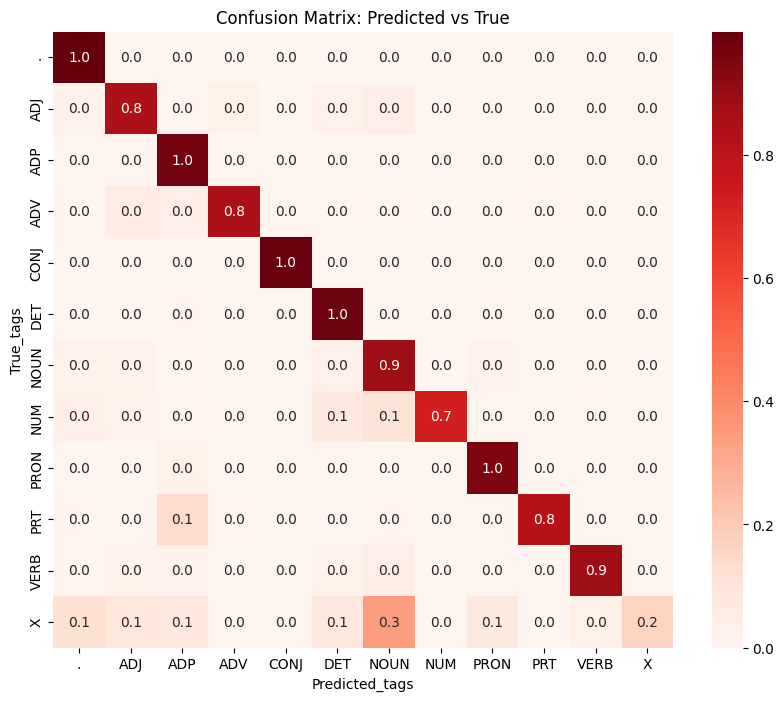

+------+-----------+--------+----------+
| Tag  | Precision | Recall | F1-Score |
+------+-----------+--------+----------+
|  .   |    0.93   |  1.00  |   0.97   |
| ADJ  |    0.84   |  0.85  |   0.85   |
| ADP  |    0.90   |  0.97  |   0.93   |
| ADV  |    0.89   |  0.84  |   0.87   |
| CONJ |    0.98   |  0.99  |   0.99   |
| DET  |    0.89   |  0.99  |   0.94   |
| NOUN |    0.94   |  0.88  |   0.91   |
| NUM  |    0.99   |  0.73  |   0.84   |
| PRON |    0.86   |  0.96  |   0.90   |
| PRT  |    0.90   |  0.82  |   0.86   |
| VERB |    0.97   |  0.88  |   0.92   |
|  X   |    0.65   |  0.17  |   0.27   |
+------+-----------+--------+----------+

Overall Metrics:
Precision:  0.92
Recall:     0.92
F1-Score:   0.92
F2-Score:   0.92
F0.5-Score: 0.92


In [ ]:

full_dataset = brown.tagged_sents(tagset='universal')
print(f"Total sents = {len(full_dataset)}")

predictions = []
truths = []
confusion = np.zeros((len(tags), len(tags)))

tags = sorted(list(tags))
if '^' in tags:
    tags.remove('^')
tag_to_i = dict([(j, i) for (i, j) in enumerate(tags)])

def calculate_accuracy(row):
    sent, true_tags = zip(*row)
    pred = model.tag_pos(sent)
    predictions.extend(pred)
    truths.extend(true_tags)
    for i, j in zip(true_tags, pred):
        if i == '^' or j == '^':
            continue
        confusion[tag_to_i[i]][tag_to_i[j]] += 1
    return sum(x == y for x, y in zip(true_tags, pred))


cumulative_confusion = np.zeros((len(tags), len(tags)))
cumulative_correct = 0
cumulative_total = 0


kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(full_dataset):
    train_set = [full_dataset[i] for i in train_index]
    test_set = [full_dataset[i] for i in test_index]

    model = HMM(smoothing=1)
    model.train(train_set)


    confusion = np.zeros((len(tags), len(tags)))


    correct = sum(calculate_accuracy(row) for row in test_set)
    total = sum(len(row) for row in test_set)

    cumulative_correct += correct
    cumulative_total += total

    print(f"Fold Test accuracy: {100 * correct / total:.2f}%")


    cumulative_confusion += confusion


final_accuracy = 100 * cumulative_correct / cumulative_total
print(f"Overall Test accuracy: {final_accuracy:.2f}%")


conf = (cumulative_confusion.T / (cumulative_confusion.sum(axis=1))).T
conf = np.nan_to_num(conf)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf, annot=True, fmt=".1f", cmap="Reds", xticklabels=tags, yticklabels=tags)
plt.xlabel('Predicted_tags')
plt.ylabel('True_tags')
plt.title('Confusion Matrix: Predicted vs True')
ax.set_ylim(len(tags), 0)
plt.show()


def calculate_metrics(cumulative_confusion):
    tag_metrics = {}
    overall_precision_numerator = 0
    overall_recall_numerator = 0
    total_tag_occurrences = 0

    for i, tag in enumerate(tags):
        true_positives = cumulative_confusion[i][i]
        false_positives = np.sum(cumulative_confusion[:, i]) - true_positives
        false_negatives = np.sum(cumulative_confusion[i, :]) - true_positives

        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0.0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

        tag_metrics[tag] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}


        tag_total = np.sum(cumulative_confusion[i, :])
        if tag_total > 0:
            total_tag_occurrences += tag_total
            overall_precision_numerator += precision * tag_total
            overall_recall_numerator += recall * tag_total

    if total_tag_occurrences > 0:
        overall_precision = overall_precision_numerator / total_tag_occurrences
        overall_recall = overall_recall_numerator / total_tag_occurrences
        overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall)


        overall_f2_score = (1 + 2**2) * (overall_precision * overall_recall) / ((2**2 * overall_precision) + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0
        overall_f0_5_score = (1 + 0.5**2) * (overall_precision * overall_recall) / ((0.5**2 * overall_precision) + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0
    else:
        overall_precision = overall_recall = overall_f1_score = overall_f2_score = overall_f0_5_score = 0.0

    return tag_metrics, overall_precision, overall_recall, overall_f1_score, overall_f2_score, overall_f0_5_score


metrics, overall_precision, overall_recall, overall_f1_score, overall_f2_score, overall_f0_5_score = calculate_metrics(cumulative_confusion)


table = PrettyTable(["Tag", "Precision", "Recall", "F1-Score"])
for tag, scores in metrics.items():
    table.add_row([tag, f"{scores['precision']:.2f}", f"{scores['recall']:.2f}", f"{scores['f1_score']:.2f}"])
print(table)


print("\nOverall Metrics:")
print(f"Precision:  {overall_precision:.2f}")
print(f"Recall:     {overall_recall:.2f}")
print(f"F1-Score:   {overall_f1_score:.2f}")
print(f"F2-Score:   {overall_f2_score:.2f}")
print(f"F0.5-Score: {overall_f0_5_score:.2f}")

# Section2 : Testing and Benchmarking

In [ ]:
import re

def add_space_between_word_and_punctuation(text):
  return re.sub(r'(\w)([.,;!?])', r'\1 \2', text)

In [ ]:
import ast
import pandas as pd

acc = []

def compare_generated_tags_with_csv(hmm_model, csv_file_path):


    df = pd.read_csv(csv_file_path)


    for idx, row in df.iterrows():
        sentence = row['Sentences']
        true_pos_tags = ast.literal_eval(row['Final POS Tags'])


        words = add_space_between_word_and_punctuation(sentence).split()
        Total_count = len(words)


        generated_tags = hmm_model.tag_pos(words)


        print(f"Sentence {idx+1}: {sentence}\n")
        print()
        print("Word Count: ", Total_count)
        print()
        print("Generated Tags:", generated_tags)
        print()
        print("True Tags:", true_pos_tags)
        print()


        mismatches = [(word, generated_tag, true_pos_tags.get(word))
                      for word, generated_tag in zip(words, generated_tags) if true_pos_tags.get(word) != generated_tag]

        Correct_count = Total_count - len(mismatches)
        print("Matched: ", Correct_count)
        print()

        if mismatches:
            print("Mismatches found:\n")
            for mismatch in mismatches:
                print(f"Word: {mismatch[0]} | Generated: {mismatch[1]} | Expected: {mismatch[2]}")
        else:
            print("All tags match!\n\n")

        acc.append(Correct_count/Total_count)

        print()
        print()
        print()
        print()


In [ ]:
import pandas as pd


csv_file_path = '/content/CS626_assignment/HMM_final_with_period.csv'
df = pd.read_csv(csv_file_path)


df.head()


,Sentences,Final POS Tags
0,The students were excited about the upcoming f...,"{'The': 'DET', 'students': 'NOUN', 'were': 'VE..."
1,She drinks coffee every morning.,"{'She': 'PRON', 'drinks': 'VERB', 'coffee': 'N..."
2,The flowers are blooming in the spring.,"{'The': 'DET', 'flowers': 'NOUN', 'are': 'VERB..."
3,The sun is shining brightly today.,"{'The': 'DET', 'sun': 'NOUN', 'is': 'VERB', 's..."
4,The couple enjoyed a quiet evening by the fire...,"{'The': 'DET', 'couple': 'NOUN', 'enjoyed': 'V..."


In [ ]:
compare_generated_tags_with_csv(model,csv_file_path)

Sentence 1: The students were excited about the upcoming field trip to the science museum, where they would see dinosaur fossils.


Word Count:  21

Generated Tags: ['DET', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', '.', 'ADV', 'PRON', 'VERB', 'VERB', 'ADP', 'NOUN', '.']

True Tags: {'The': 'DET', 'students': 'NOUN', 'were': 'VERB', 'excited': 'ADJ', 'about': 'ADP', 'the': 'DET', 'upcoming': 'ADJ', 'field': 'NOUN', 'trip': 'NOUN', 'to': 'ADP', 'science': 'NOUN', 'museum': 'NOUN', ',': '.', 'where': 'ADV', 'they': 'PRON', 'would': 'VERB', 'see': 'VERB', 'dinosaur': 'NOUN', 'fossils': 'NOUN', '.': '.'}

Matched:  19

Mismatches found:

Word: excited | Generated: VERB | Expected: ADJ
Word: dinosaur | Generated: ADP | Expected: NOUN




Sentence 2: She drinks coffee every morning.


Word Count:  6

Generated Tags: ['PRON', 'VERB', 'ADP', 'DET', 'NOUN', '.']

True Tags: {'She': 'PRON', 'drinks': 'VERB', 'coffee': 'NOUN', 'every': 'DET', 'morni

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(hmm_model, csv_file_path):


    df = pd.read_csv(csv_file_path)

    true_tags = []
    predicted_tags = []


    for idx, row in df.iterrows():
        sentence = row['Sentences']
        true_pos_tags = ast.literal_eval(row['Final POS Tags'])


        words = add_space_between_word_and_punctuation(sentence).split()


        generated_tags = hmm_model.tag_pos(words)


        for word, tag in zip(words, generated_tags):
            true_tags.append(true_pos_tags.get(word, 'UNKNOWN'))
            predicted_tags.append(tag)


    labels = sorted(set(true_tags + predicted_tags))


    cm = confusion_matrix(true_tags, predicted_tags, labels=labels)


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('HMM POS Tagging')
    plt.ylabel('ChatGPT POS Tagging')
    plt.title('Confusion Matrix: HMM vs ChatGPT')
    plt.show()

## 1)Comparison with ChatGPT

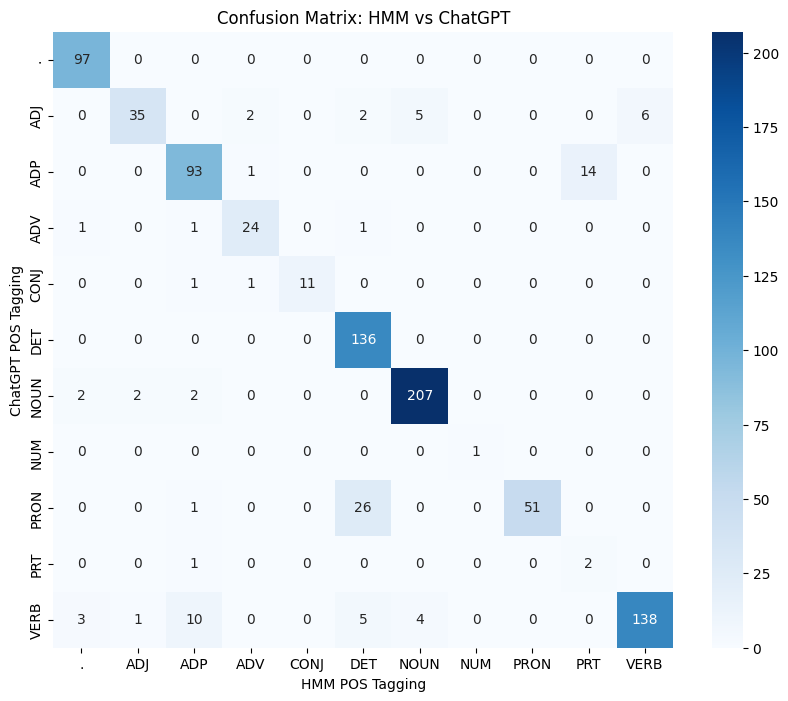

In [ ]:
generate_confusion_matrix(model, '/content/CS626_assignment/HMM_final_with_period.csv')

In [ ]:
!pip install gradio

##2)Demo

In [ ]:
import gradio as gr


model = HMM()
model.train(full_dataset)

def tag_and_print_sentence(sentence, model):
    words = sentence.split()

    predicted_tags = model.tag_pos(words)


    return list(zip(words, predicted_tags))


def process_sentence(sentence):
    if sentence:
        pos_tags = tag_and_print_sentence(add_space_between_word_and_punctuation(sentence), model)


        formatted_output = "<br>".join([f'<span style="color:white; font-size: 30px;"><b>{word}</b></span><span style="color:white; font-size: 30px;"><b>  ->  </b></span><span style="color:red; font-size: 30px;"><b>{tag}</b></span>' for word, tag in pos_tags])


        return formatted_output
    else:
        return "Please enter a sentence."


with gr.Blocks() as demo:
    gr.Markdown("# POS Tagger using HMM")

    sentence_input = gr.Textbox(label="Enter a sentence:")


    pos_output = gr.HTML(label="POS Tags")


    btn = gr.Button("Tag Sentence")
    btn.click(fn=process_sentence, inputs=sentence_input, outputs=pos_output)


demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://be2f9facdbd3d731ea.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
